# Incorporate python functions and classes  in a model 
An exampel of how to use the funks=[list of function] to introduce user defined python functions in a model 

Also notice how several variables on the ledft hand side of the =. They will alll be considered endogeneous variables. 

In [2]:
#Required packages
import pandas as pd

# Modelflow modules
from modelclass import model
   
#for publication 
latex=0
model.widescreen()


## Specify the a class which defines functions to incorporate in model  


In [3]:
from dataclasses import dataclass, field

@dataclass 

class fftpoc():
    '''A  silly class which is initialiced and contains a functionwhich can be called from modelflow.
    in FTT context it should initialize the FTT model and define functions which can be called. 
    '''    
    
    base_price_coal : float =  100 
    base_price_oil  : float =  200 
    base_year       : int   = 2019 
    pricegrowth     : float =  0.01 
        
    def get_prices(self,year,labor=100):
        current_price_coal = self.base_price_coal* (1+self.pricegrowth)**(year-self.base_year) 
        current_price_oil  = self.base_price_oil * (1+self.pricegrowth)**(year-self.base_year) 
        return current_price_coal, current_price_oil,labor 
        
this_instance = fftpoc()   # make an instance 

get_prices =  this_instance.get_prices   # Fefine a function which can be included in the modelflow business languiage. 
get_prices(2023) # test that we get a number 

(104.060401, 208.120802, 100)

In [4]:
this_instance

fftpoc(base_price_coal=100, base_price_oil=200, base_year=2019, pricegrowth=0.01)

## Two functions to incorporate 

In [9]:
def labor_dif(growth,last):
    return growth*last

In [10]:
def answer(growth):
    return 42,34

## Specify the model 


In [11]:

fsolow2 = '''\
Income          = a  * Capital**alfa * Labor **(1-alfa) 
Consumption     = (1-saving_rate)  * Income 
Investment      = Income - Consumption   
diff(Capital)   = Investment-Depreciation_rate * Capital(-1)
diff(Labor)     = labor_dif(Labor_growth,Labor(-1))  
Capital_intensity = Capital/Labor 
ibh,b = answer(Labor_growth)
horse =  ibh *b 
coal_price, oil_price, extralabor = get_prices(year,labor)
'''

## Create a model class instance

After defining the Business Logic Language and storing it in the variable 'fsolow', we create a class instance called msolow

Notice the funks=[list of functions]

In [12]:
msolow = model.from_eq(fsolow2,modelname='Solow model',funks=[labor_dif,answer,get_prices])

In [13]:
msolow.print_model

FRML <> INCOME          = A  * CAPITAL**ALFA * LABOR **(1-ALFA)  $
FRML <> CONSUMPTION     = (1-SAVING_RATE)  * INCOME  $
FRML <> INVESTMENT      = INCOME - CONSUMPTION    $
FRML <> CAPITAL=CAPITAL(-1)+(INVESTMENT-DEPRECIATION_RATE * CAPITAL(-1))$
FRML <> LABOR=LABOR(-1)+(LABOR_DIF(LABOR_GROWTH,LABOR(-1)))$
FRML <> CAPITAL_INTENSITY = CAPITAL/LABOR  $
FRML <> IBH,B = ANSWER(LABOR_GROWTH) $
FRML <> HORSE =  IBH *B  $
FRML <> COAL_PRICE, OIL_PRICE, EXTRALABOR = GET_PRICES(YEAR,LABOR) $


## Create some data 

To show what Modelflow can do, we create a Pandas dataframe with input data. And print the first 5 out of 300 observations.  

In [14]:
N = 300  
df = pd.DataFrame({'LABOR':[100]*N,
                   'CAPITAL':[100]*N, 
                   'ALFA':[0.5]*N, 
                   'A': [1]*N, 
                   'DEPRECIATION_RATE': [0.05]*N, 
                   'LABOR_GROWTH': [0.01]*N, 
                   'SAVING_RATE':[0.05]*N,
                   'YEAR': [2020 + i for i in range(N)] })
df.head(2) #this prints out the first 5 rows of the dataframe

,LABOR,CAPITAL,ALFA,A,DEPRECIATION_RATE,LABOR_GROWTH,SAVING_RATE,YEAR
0,100,100,0.5,1,0.05,0.01,0.05,2020
1,100,100,0.5,1,0.05,0.01,0.05,2021


## Run the model 

In [15]:
result = msolow(df,keep='Baseline') # The model is simulated for all years possible 
result.head(5)

,LABOR,CAPITAL,ALFA,A,DEPRECIATION_RATE,LABOR_GROWTH,SAVING_RATE,YEAR,B,COAL_PRICE,CONSUMPTION,IBH,INVESTMENT,OIL_PRICE,HORSE,EXTRALABOR,INCOME,CAPITAL_INTENSITY
0,100.000000,100.000000,0.5,1.0,0.05,0.01,0.05,2020.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,101.000000,100.025580,0.5,1.0,0.05,0.01,0.05,2021.0,34.0,102.010000,95.486029,42.0,5.025580,204.020000,1428.0,101.000000,100.511609,0.990352
2,102.010000,100.076226,0.5,1.0,0.05,0.01,0.05,2022.0,34.0,103.030100,95.986562,42.0,5.051924,206.060200,1428.0,102.010000,101.038487,0.981043
3,103.030100,100.151443,0.5,1.0,0.05,0.01,0.05,2023.0,34.0,104.060401,96.501546,42.0,5.079029,208.120802,1428.0,103.030100,101.580575,0.972060
4,104.060401,100.250762,0.5,1.0,0.05,0.01,0.05,2024.0,34.0,105.101005,97.030930,42.0,5.106891,210.202010,1428.0,104.060401,102.137821,0.963390


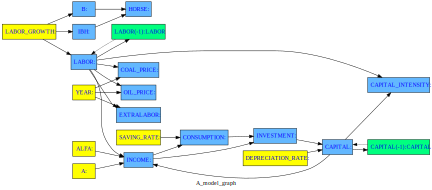

In [16]:
msolow.drawmodel()